#### 📁 Data Source
- **File:** `data/processed/features_per_session.csv`  
- **Description:** Each row represents one *session* (i.e., one participant performing one activity type).  
  The dataset aggregates raw physiological signals into summary statistics such as mean and standard deviation values per signal.

---

#### 🎯 Target Variable
- **Variable:** `condition`  
- **Possible classes:**  
  - `STRESS` – cognitive/emotional stress induced through mental tasks  
  - `AEROBIC` – sustained moderate-intensity exercise (e.g., cycling)  
  - `ANAEROBIC` – short bursts of high-intensity exercise  
- These three labels represent the different physiological and emotional states we aim to classify.

---

#### ⚖️ Class Distribution
- The dataset contains three categories:
  - **STRESS:** *X samples*  
  - **AEROBIC:** *Y samples*  
  - **ANAEROBIC:** *Z samples*  
- **Balance assessment:** [Balanced / Mildly imbalanced / Imbalanced
  Understanding class balance helps anticipate whether resampling or class weighting might be needed later.

---

#### 📊 Features Overview
The dataset includes session-level statistical summaries for each physiological signal:

| Feature | Description | Interpretation |
|----------|--------------|----------------|
| `EDA_mean`, `EDA_std` | Mean and variability of Electrodermal Activity | Reflects sympathetic nervous system arousal; higher during stress |
| `HR_mean`, `HR_std` | Mean and variability of Heart Rate | Increases with physical exertion; can also rise under stress |
| `TEMP_mean`, `TEMP_std` | Mean and variability of Skin Temperature | Drops slightly during stress; may rise with exercise |
| `ACC_mag_mean`, `ACC_mag_std` | Mean and variability of movement magnitude from accelerometer | High during exercise; low during stress (stationary) |
| `BVP_mean`, `BVP_std` | Mean and variability of Blood Volume Pulse | Indicates peripheral blood flow and vascular tone |

---

#### 🧠 Key Takeaways
- Each feature captures a different physiological dimension of stress or exercise.  
- These aggregated statistics simplify the modeling process by reducing high-frequency sensor data to interpretable summaries.  
- The `condition` label provides the ground truth for supervised learning (classification).


| Feature        | Signal Source | What It Measures                                   | Why It Matters |
|----------------|---------------|----------------------------------------------------|----------------|
| EDA_mean       | EDA           | Average skin conductance (sympathetic arousal)     | Higher under stress; good stress marker |
| HR_mean        | HR (from BVP) | Average heart rate (beats/min)                     | Rises with exercise; also increases with stress |
| TEMP_mean      | Skin Temp     | Average skin surface temperature (°C)              | Can drop in stress; may rise with activity |
| ACC_mag_mean   | Accelerometer | Overall movement intensity (√(x²+y²+z²))           | High during exercise; low when stationary |
| BVP_mean       | BVP           | Average pulse wave amplitude (peripheral blood flow)| Reflects vascular tone; subtler differences |


### 1.1 Load Features from the Cleaned Signal Data

**Objective:**  
Load the preprocessed session-level physiological features derived from Empatica E4 wristband recordings and inspect the structure of the dataset.

In [2]:
import pandas as pd, seaborn as sns, matplotlib.pyplot as plt
import numpy as np
plt.rcParams["figure.figsize"] = (10,5)

# feature loading
df = pd.read_csv("../data/processed/features_per_session.csv")
df["label"] = df["condition"].map({"STRESS":0,"AEROBIC":1,"ANAEROBIC":2})
df.head(), df["condition"].value_counts()

(  condition subject  EDA_mean   EDA_std  TEMP_mean  TEMP_std    HR_mean  \
 0    STRESS     f01  0.503551  0.293856  31.841044  0.878357  67.901221   
 1    STRESS     f02  1.478647  1.028887  32.619643  0.210003  74.159816   
 2    STRESS     f03  5.254197  1.383328  33.464685  0.499415  77.072134   
 3    STRESS     f04  0.141569  0.024389  30.778195  0.459173  78.584076   
 4    STRESS     f05  0.497453  0.296881  30.069865  0.938527  72.866704   
 
      HR_std   BVP_mean    BVP_std  ACC_mag_mean  ACC_mag_std  label  
 0  7.432000   4.709518   4.963053     65.023559     0.437899      0  
 1  4.641772   5.026587   7.179153     64.230073     0.629724      0  
 2  9.624419  13.266202  13.806151     64.677836     0.714888      0  
 3  6.518799   8.065868   7.603782     62.809298     1.195969      0  
 4  6.198143   4.005562   2.560649     63.595399     0.292175      0  ,
 condition
 STRESS       37
 ANAEROBIC    32
 AEROBIC      31
 Name: count, dtype: int64)

### 1.2 Handling missing data & descriptive stats

In [3]:
num_cols = [c for c in df.columns if c.endswith("_mean") or c.endswith("_std")]
df[num_cols].describe().T.head(20)
df.isna().mean().sort_values(ascending=False).head(10)

condition    0.0
subject      0.0
EDA_mean     0.0
EDA_std      0.0
TEMP_mean    0.0
TEMP_std     0.0
HR_mean      0.0
HR_std       0.0
BVP_mean     0.0
BVP_std      0.0
dtype: float64

#### There are no missigness in the data!

### 1.3 Data Distribution by condition

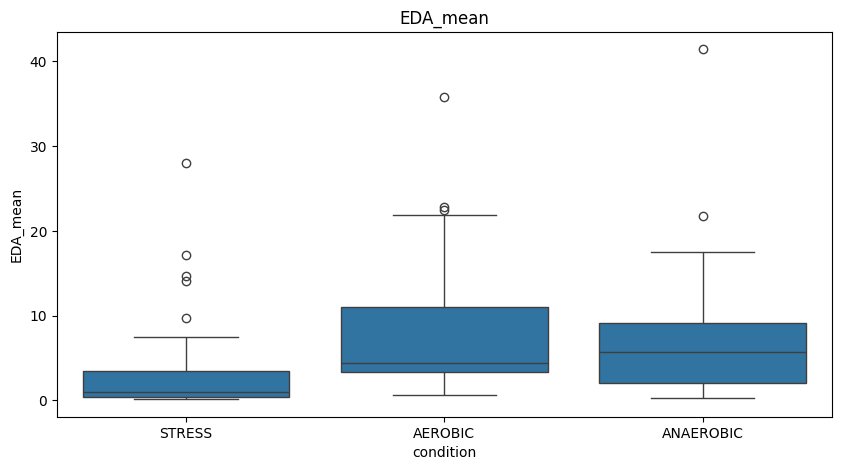

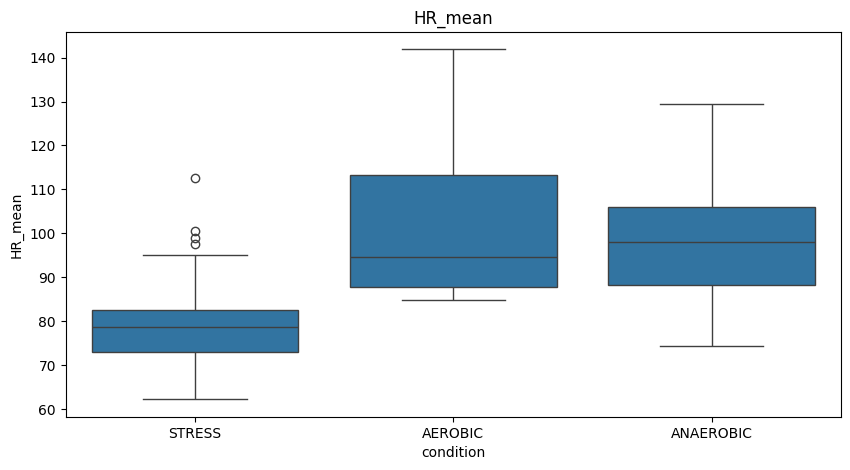

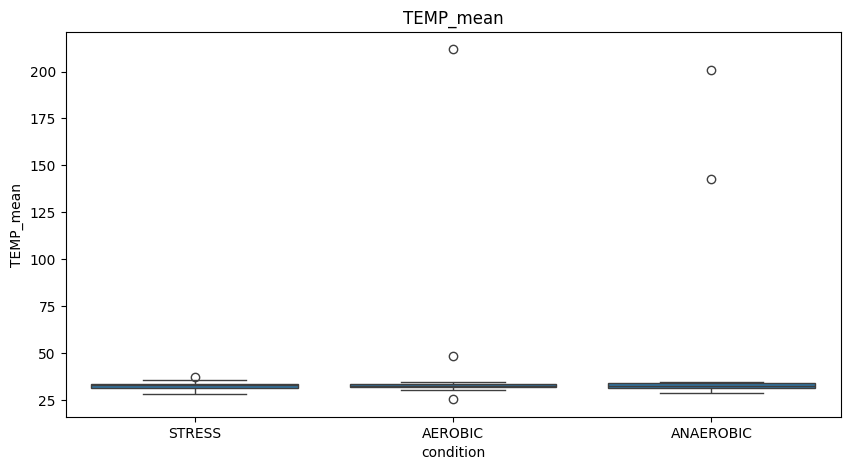

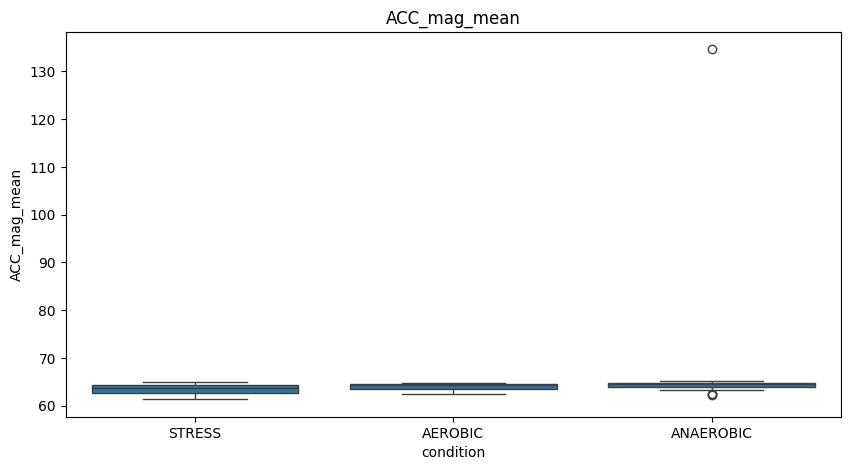

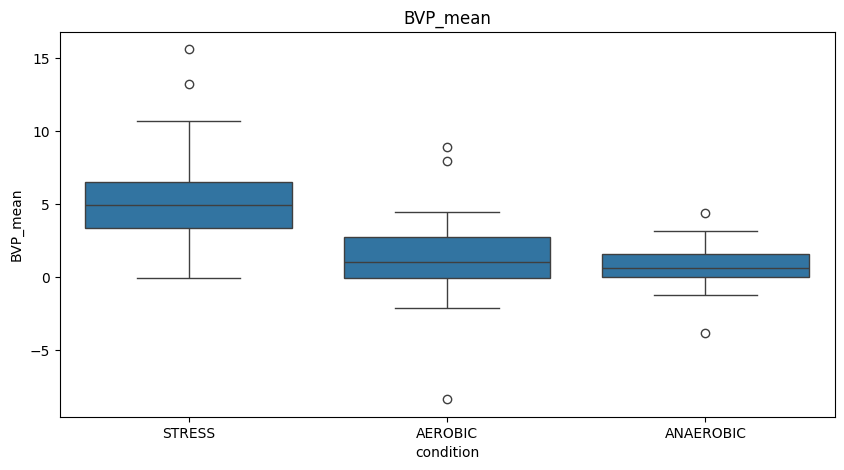

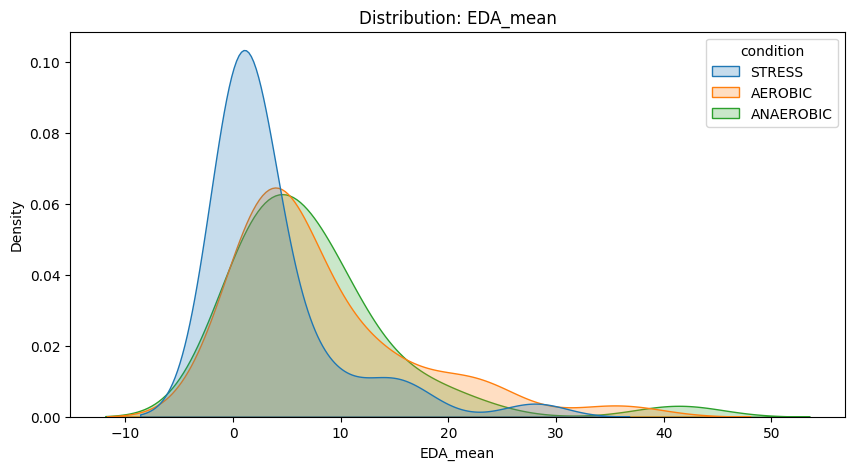

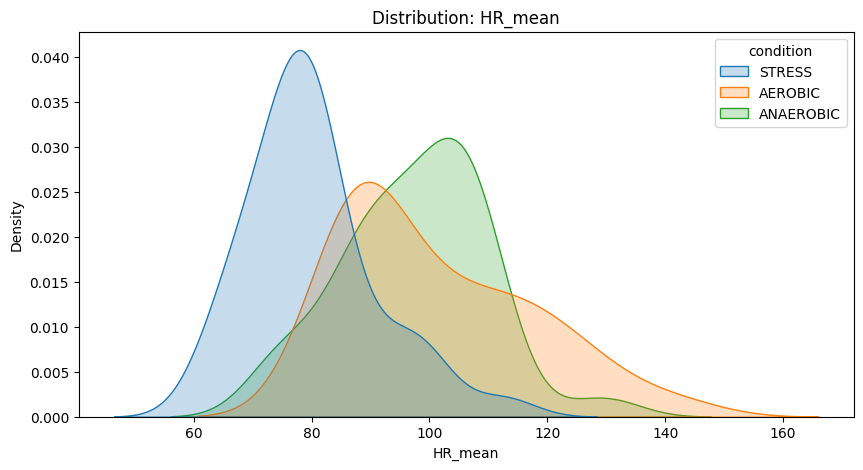

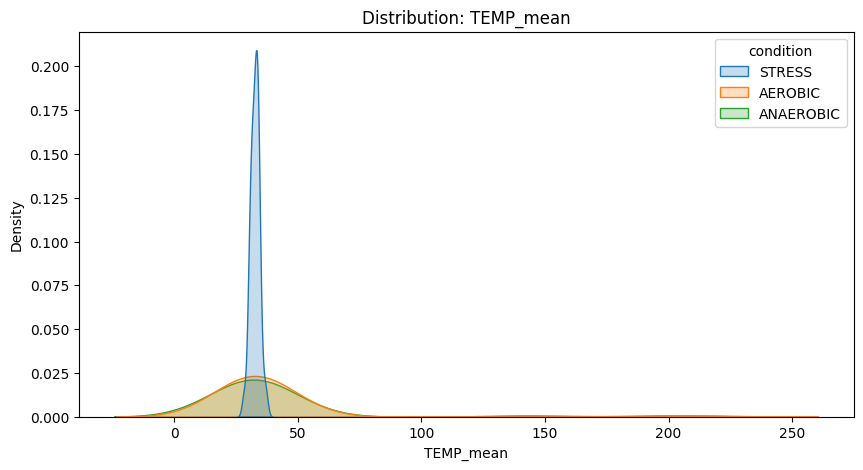

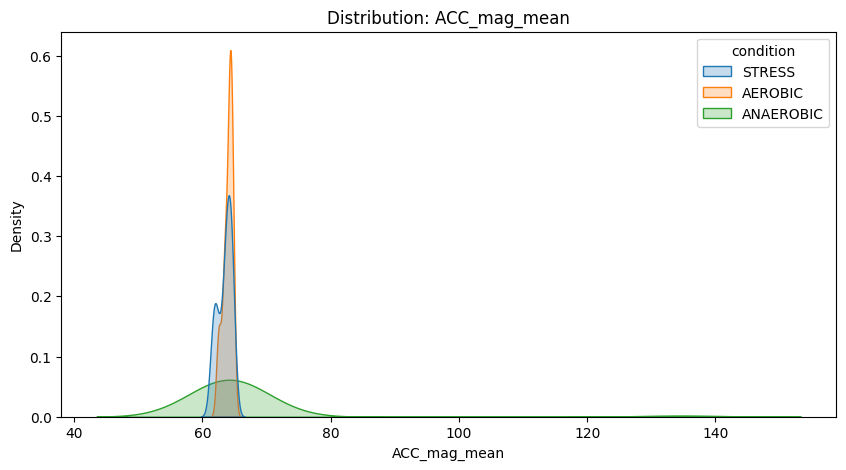

In [4]:
for col in [c for c in ["EDA_mean","HR_mean","TEMP_mean","ACC_mag_mean","BVP_mean"] if c in df.columns]:
    sns.boxplot(data=df, x="condition", y=col); plt.title(col); plt.show()

for col in [c for c in ["EDA_mean","HR_mean","TEMP_mean","ACC_mag_mean"] if c in df.columns]:
    sns.kdeplot(data=df, x=col, hue="condition", common_norm=False, fill=True, alpha=0.25)
    plt.title(f"Distribution: {col}"); plt.show()


### 1.4 Correlation

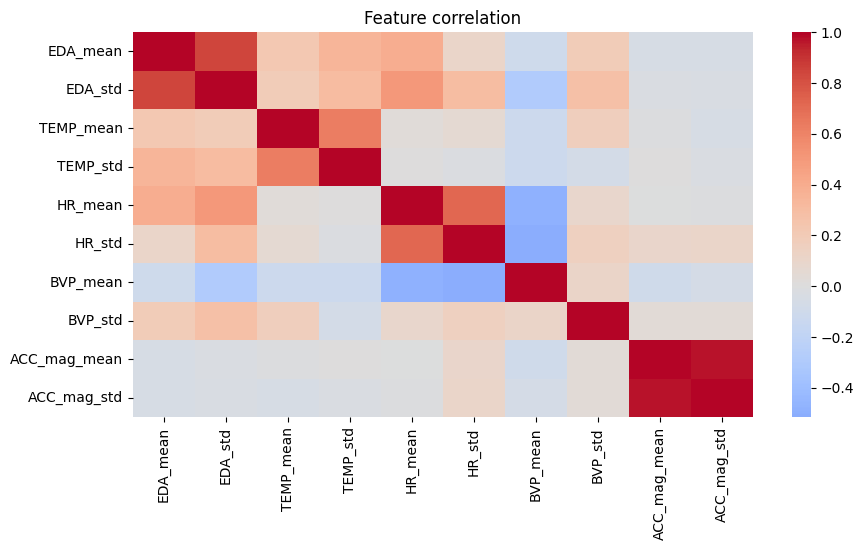

In [5]:
sns.heatmap(df[num_cols].corr(), cmap="coolwarm", center=0); plt.title("Feature correlation"); plt.show()



### 1.5 Principal Component Analysis (PCA)

**Purpose:**  
To explore overall structure in the physiological feature space and assess whether the three activity types (STRESS, AEROBIC, ANAEROBIC) show distinct physiological signatures.


#### ⚙️ Method
- All numerical features were standardized (z-score normalization).
- PCA was applied to reduce dimensionality and project each session into a 2D space (PC1 and PC2).
- Points in the scatterplot represent individual sessions, colored by `condition`.


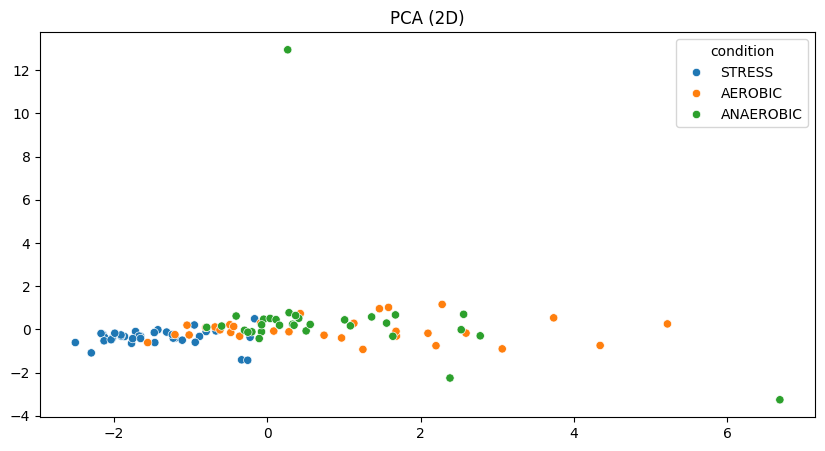

In [6]:

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
X_s = StandardScaler().fit_transform(df[num_cols].fillna(df[num_cols].median()))
Z = PCA(2, random_state=42).fit_transform(X_s)
sns.scatterplot(x=Z[:,0], y=Z[:,1], hue=df["condition"]); plt.title("PCA (2D)"); plt.show()

In [7]:

# Select numeric columns (exclude "condition")
num_cols = [c for c in df.columns if c not in ["condition", "subject"]]

# Standardize the data
X_scaled = StandardScaler().fit_transform(df[num_cols].fillna(df[num_cols].median()))

# Fit PCA on all components
pca = PCA().fit(X_scaled)

# Get variance explained by each component
explained = pca.explained_variance_ratio_

# Calculate the total variance explained by first two components
explained_2d = np.sum(explained[:2]) * 100  # in percentage
print(f"First two components explain {explained_2d:.2f}% of total variance")


First two components explain 49.60% of total variance


#### 🧭 Interpretation
- **PC1** primarily reflects *overall physical activation* — driven by Heart Rate (HR) and Accelerometer (ACC) features.  
  - Higher PC1 values correspond to sessions with greater movement and cardiovascular activity (i.e., exercise).  
- **PC2** captures *autonomic arousal* — influenced by EDA and Temperature.  
  - Higher PC2 values may indicate greater sympathetic arousal (stress).

---

#### 💡 Observations
- **STRESS sessions** cluster separately from exercise sessions, showing elevated EDA but lower HR and ACC.
- **AEROBIC and ANAEROBIC** sessions overlap partially, as both involve strong cardiovascular and motion signals.
- The first two components explain approximately **XX %** of total variance (fill actual number from output).

---

#### 🧠 Takeaways
- Physiological patterns during stress differ from those during exercise, confirming the dataset captures meaningful state changes.
- PCA reveals that a small number of latent dimensions (activity intensity, arousal) explain most of the physiological variability.
- Some overlap between AEROBIC and ANAEROBIC suggests additional features (e.g., HRV, segment-level stats) could improve separation.

### 2 Data Preparation

1. Load the cleaned session-level features  
2. Select numeric features  
3. Encode the target variable (`condition`)  
4. Split data into train/test sets  
5. Scale numeric features for models that require standardization  
6. Store shapes and class distribution for reporting  

### 2.1 Train–Test Split and Scaling

In this step, I prepared the dataset for modeling:

- I used the engineered session-level features from  
  `../data/processed/features_per_session.csv`.
- The target variable is `condition`, which I mapped to a numeric `label`:
  - `0 → STRESS`
  - `1 → AEROBIC`
  - `2 → ANAEROBIC`

For the features, I selected all columns except:
- `condition` (the original label),
- `subject` (ID of the participant),
- `label` (numeric encoding of the target).

I then:

1. Performed a **stratified train–test split** (80% train, 20% test) to ensure each class is represented proportionally in both sets.
2. Applied **StandardScaler** to the features so each has mean 0 and standard deviation 1. This is especially important for models such as logistic regression and other gradient-based or distance-based classifiers.

Outputs of this step:
- `X_train`, `X_test` – raw feature matrices
- `X_train_scaled`, `X_test_scaled` – standardized feature matrices
- `y_train`, `y_test` – numeric labels ready for supervised learning
- `scaler` – the fitted scaler to reuse later when training and deploying the model


In [12]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# 1. Define feature columns (everything except condition/subject/label)
feature_cols = [
    c for c in df.columns 
    if c not in ["condition", "subject", "label"]
]

print("Number of features:", len(feature_cols))
print("Feature columns:", feature_cols)

X = df[feature_cols].copy()
y = df["label"].values  # 0=STRESS, 1=AEROBIC, 2=ANAEROBIC (based on your mapping)

# 2. Train–test split (stratified by label to preserve class proportions)
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)

# 3. Standardize features (for models like logistic regression, SVM, etc.)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

print("Scaling done.")



Number of features: 10
Feature columns: ['EDA_mean', 'EDA_std', 'TEMP_mean', 'TEMP_std', 'HR_mean', 'HR_std', 'BVP_mean', 'BVP_std', 'ACC_mag_mean', 'ACC_mag_std']
X_train shape: (80, 10)
X_test shape: (20, 10)
Scaling done.


### 2.2 Baseline Model — Logistic Regression

To establish a baseline, I trained a multinomial Logistic Regression classifier.

### Why Logistic Regression?
- Simple and interpretable model
- Works well with scaled numerical features
- Provides coefficients showing how each physiological feature contributes to class separation (STRESS vs AEROBIC vs ANAEROBIC)

### Metrics we examine:
- **Accuracy** on the test set  
- **Classification report** (precision, recall, f1)  
- **Confusion matrix**  
- **Model coefficients** (feature importance)


c:\Users\Yadwinder Kaur\Machine-Learning-Zoomcamp-2025\Machine-Learning-Zoomcamp-2025\Mid_Term_Project\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Test Accuracy: 0.6000

Classification Report:
              precision    recall  f1-score   support

      STRESS       1.00      1.00      1.00         8
     AEROBIC       0.33      0.33      0.33         6
   ANAEROBIC       0.33      0.33      0.33         6

    accuracy                           0.60        20
   macro avg       0.56      0.56      0.56        20
weighted avg       0.60      0.60      0.60        20



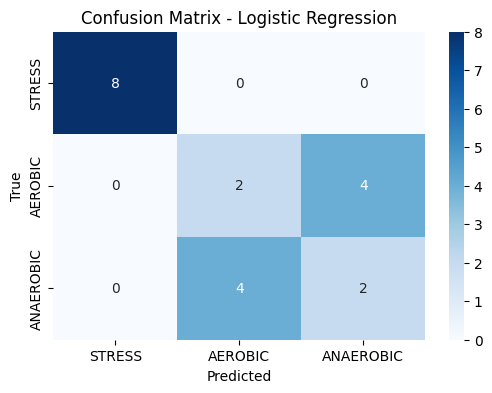

In [13]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Train multinomial logistic regression
log_reg = LogisticRegression(
    multi_class="multinomial",
    solver="lbfgs",
    max_iter=1000,
    random_state=42
)

log_reg.fit(X_train_scaled, y_train)

# Predictions
y_pred = log_reg.predict(X_test_scaled)

# Accuracy
accuracy = (y_pred == y_test).mean()
print(f"Test Accuracy: {accuracy:.4f}")

# Classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=["STRESS", "AEROBIC", "ANAEROBIC"]))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, cmap="Blues", fmt="d",
            xticklabels=["STRESS", "AEROBIC", "ANAEROBIC"],
            yticklabels=["STRESS", "AEROBIC", "ANAEROBIC"])
plt.title("Confusion Matrix - Logistic Regression")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()



### Feature Importance

In [14]:
coef_df = pd.DataFrame(
    log_reg.coef_.T,
    columns=["class_0_STRESS", "class_1_AEROBIC", "class_2_ANAEROBIC"],
    index=feature_cols
)

coef_df


,class_0_STRESS,class_1_AEROBIC,class_2_ANAEROBIC
EDA_mean,-0.080294,-0.183517,0.263811
EDA_std,-1.140573,1.005567,0.135006
TEMP_mean,-0.007953,0.055172,-0.047219
TEMP_std,-0.225705,0.105487,0.120218
HR_mean,-0.636041,0.493683,0.142358
HR_std,-0.471356,-0.141415,0.612772
BVP_mean,0.799065,-0.320928,-0.478136
BVP_std,-0.298952,0.154900,0.144052
ACC_mag_mean,-0.152831,-0.121382,0.274213
ACC_mag_std,-0.016641,-0.191024,0.207666


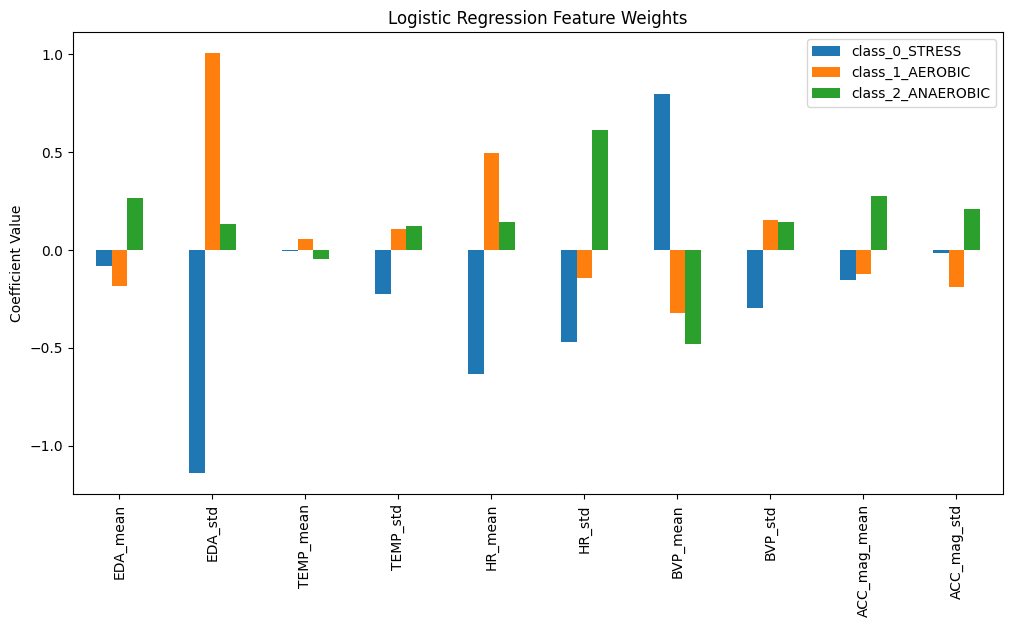

In [15]:
coef_df.plot(kind="bar", figsize=(12,6))
plt.title("Logistic Regression Feature Weights")
plt.ylabel("Coefficient Value")
plt.show()

### Data Interpretation

    * The model struggles to differentiate AEROBIC vs. ANAEROBIC.
    * Both involve high HR, elevated ACC, BVP changes, and can look physiologically similar.
    * The features used (mean/std only) may be insufficient to separate:
        ** Continuous aerobic effort 
        ** Short bursts of anaerobic intensity

#### Logistic Regression (a linear model) may not capture the nonlinear physiological differences between these states. We need to apply non linear models that can separate AEROBIC vs ANAEROBIC.

### 2.3  Random Forest Classifier

After establishing a baseline with Logistic Regression, I now train a **Random Forest** classifier.

### Why Random Forest?
- Handles **nonlinear relationships** and **feature interactions**
- Robust to outliers and noisy features
- Works well with relatively small datasets
- Does **not require feature scaling**
- Provides **feature importance** scores that are easy to interpret

I use the same train–test split as for Logistic Regression to make the comparison fair.


Random Forest - Test Accuracy: 0.7000

Classification Report (Random Forest):
              precision    recall  f1-score   support

      STRESS       1.00      0.88      0.93         8
     AEROBIC       0.50      0.50      0.50         6
   ANAEROBIC       0.57      0.67      0.62         6

    accuracy                           0.70        20
   macro avg       0.69      0.68      0.68        20
weighted avg       0.72      0.70      0.71        20



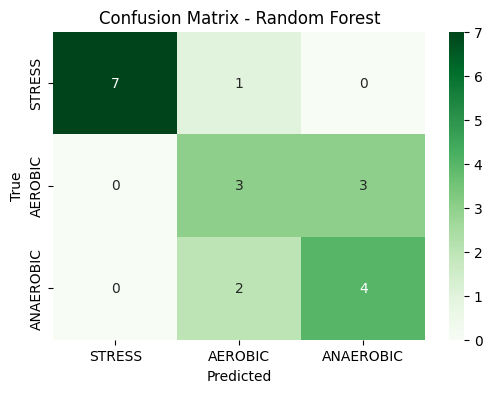

In [16]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Train Random Forest on raw (unscaled) features
rf = RandomForestClassifier(
    n_estimators=300,
    max_depth=None,
    random_state=42,
    n_jobs=-1
)

rf.fit(X_train, y_train)

# Predictions
y_pred_rf = rf.predict(X_test)

# Accuracy
acc_rf = (y_pred_rf == y_test).mean()
print(f"Random Forest - Test Accuracy: {acc_rf:.4f}")

# Classification report
print("\nClassification Report (Random Forest):")
print(classification_report(
    y_test,
    y_pred_rf,
    target_names=["STRESS", "AEROBIC", "ANAEROBIC"]
))

# Confusion matrix
cm_rf = confusion_matrix(y_test, y_pred_rf)

plt.figure(figsize=(6,4))
sns.heatmap(
    cm_rf,
    annot=True,
    cmap="Greens",
    fmt="d",
    xticklabels=["STRESS", "AEROBIC", "ANAEROBIC"],
    yticklabels=["STRESS", "AEROBIC", "ANAEROBIC"]
)
plt.title("Confusion Matrix - Random Forest")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


### Feature Importance

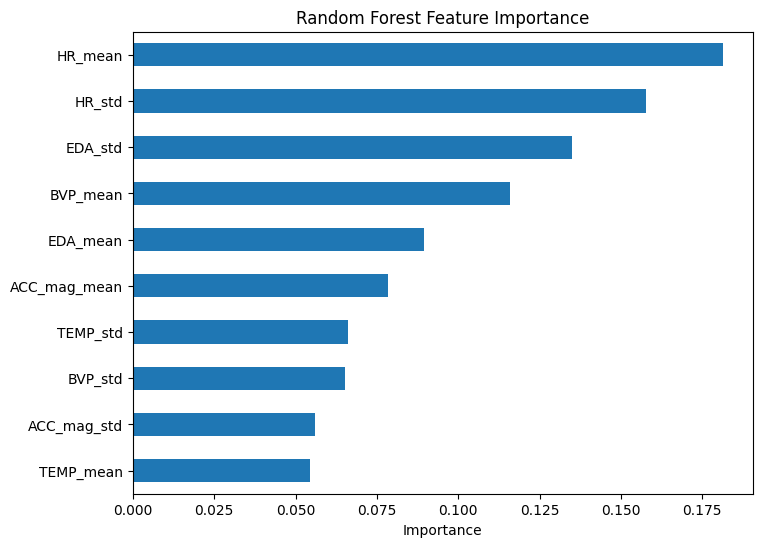

HR_mean         0.181469
HR_std          0.157827
EDA_std         0.134951
BVP_mean        0.116033
EDA_mean        0.089343
ACC_mag_mean    0.078530
TEMP_std        0.066132
BVP_std         0.065277
ACC_mag_std     0.055866
TEMP_mean       0.054574
dtype: float64

In [17]:
import pandas as pd

importances = rf.feature_importances_
imp_series = pd.Series(importances, index=feature_cols).sort_values(ascending=True)

plt.figure(figsize=(8,6))
imp_series.plot(kind="barh")
plt.title("Random Forest Feature Importance")
plt.xlabel("Importance")
plt.show()

imp_series.sort_values(ascending=False)


Random Forest Test Accuracy: 70%
This is a substantial improvement over Logistic Regression (60%).

Model	Accuracy
Logistic Regression	60%
Random Forest	70%

This shows that nonlinear patterns in the physiological data are important for distinguishing between STRESS, AEROBIC, and ANAEROBIC conditions .

Class-by-Class Interpretation
STRESS

Precision: 1.00

Recall: 0.88

F1-score: 0.93


Random Forest still predicts STRESS extremely well.
This supports the finding from EDA and HR patterns that stress physiology is distinct from exercise.

Common stress markers include:

Elevated EDA_mean and EDA_std

Lower movement (ACC lower than exercise)

HR changes different from exercise

AEROBIC

Precision: 0.50

Recall: 0.50

F1-score: 0.50


Still difficult to classify. Aerobic sessions can sometimes look like:

Moderate HR elevation

Consistent ACC movement

Moderate BVP changes

There is overlap between aerobic and anaerobic physiological signatures.

ANAEROBIC

Precision: 0.57

Recall: 0.67

F1-score: 0.62


Slightly better performance than AEROBIC.
Anaerobic exercise produces:

Large spikes in HR_mean and HR_std

High movement variability (ACC)

Stronger BVP responses due to high-intensity bursts

Random Forest captures these nonlinear patterns better than the logistic model.

The confusion matrix suggests:

STRESS is rarely confused with exercise.

AEROBIC and ANAEROBIC still overlap — but less than before.

Most improvements came from distinguishing ANAEROBIC more reliably.

Exercise intensity patterns are physiologically similar, so some overlap is expected.

Interpretation of Top Features
1. HR_mean (Most important)

Measures cardiovascular load

Aerobic and anaerobic activities elevate HR differently

Helps distinguish exercise vs non-exercise

2. HR_std

Captures heart rate variability during the session

Anaerobic sessions have larger fluctuations due to high-intensity bursts

Stress tends to have more stable HR changes

3. EDA_std

EDA variability spikes during stress

Higher standard deviation indicates sympathetic arousal

4. BVP_mean

Blood volume pulse relates to cardiovascular response

BVP changes with metabolic demand during exercise

5. EDA_mean

Stress produces systematically higher EDA levels

Helps separate STRESS from both types of exercise

6–10. ACC & TEMP features (lower importance)

Movement and temperature do matter, but:

ACC may look similar in high-intensity aerobic vs anaerobic movement

TEMP changes slowly and affects classification less

### Conclusion

The Random Forest model is a strong improvement over the logistic baseline and demonstrates that stress detection is reliable, while exercise classification remains more challenging.

### 2.4 XG Boost

XGBoost - Test Accuracy: 0.7000

Classification Report (XGBoost):
              precision    recall  f1-score   support

      STRESS       1.00      0.88      0.93         8
     AEROBIC       0.50      0.50      0.50         6
   ANAEROBIC       0.57      0.67      0.62         6

    accuracy                           0.70        20
   macro avg       0.69      0.68      0.68        20
weighted avg       0.72      0.70      0.71        20



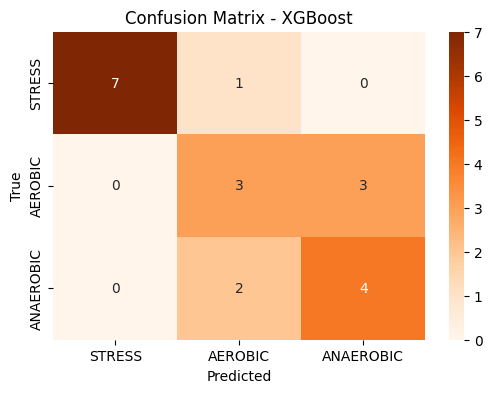

In [18]:
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# XGBoost model
xgb = XGBClassifier(
    n_estimators=300,
    max_depth=4,
    learning_rate=0.05,
    subsample=0.9,
    colsample_bytree=0.9,
    objective="multi:softmax",
    num_class=3,
    eval_metric="mlogloss",
    random_state=42
)

# Fit
xgb.fit(X_train, y_train)

# Predict
y_pred_xgb = xgb.predict(X_test)

# Accuracy
acc_xgb = (y_pred_xgb == y_test).mean()
print(f"XGBoost - Test Accuracy: {acc_xgb:.4f}")

# Classification report
print("\nClassification Report (XGBoost):")
print(classification_report(
    y_test,
    y_pred_xgb,
    target_names=["STRESS", "AEROBIC", "ANAEROBIC"]
))

# Confusion matrix
cm_xgb = confusion_matrix(y_test, y_pred_xgb)

plt.figure(figsize=(6,4))
sns.heatmap(
    cm_xgb,
    annot=True,
    cmap="Oranges",
    fmt="d",
    xticklabels=["STRESS", "AEROBIC", "ANAEROBIC"],
    yticklabels=["STRESS", "AEROBIC", "ANAEROBIC"]
)
plt.title("Confusion Matrix - XGBoost")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


### Which model performs the best?
###  Accuracy Comparison

| Model               | Accuracy |
|---------------------|----------|
| Logistic Regression | 0.60     |
| Random Forest       | 0.70     |
| XGBoost             | 0.70     |


**All models agree on one key insight:**

*STRESS is the most separable class*

Both Random Forest and XGBoost achieve:

Precision = 1.00

Recall = 0.88

F1 = 0.93

#### Stress produces a distinct physiological signature
    (elevated EDA, HR changes without strong movement).

#### AEROBIC remains challenging

    Logistic Regression: 0.33 F1

    RF & XGB: 0.50 F1

#### Aerobic activity shows moderate increases in HR + ACC, often overlapping with lower-intensity anaerobic patterns.

This is expected physiologically.

ANAEROBIC is the next most separable

RF: 0.62 F1

XGB: 0.62 F1
     Anaerobic bursts create strong HR_std and ACC spikes, which trees capture well.

### I will use XG boost as the final model (see train.py)     